## Main function test

## API Class

In [60]:
#-*- coding=utf-8 -*-
from datetime import datetime
import hashlib

class Gemtek_restful_api:
    def __init__(self, URL, api_key, api_secret, macID, index = 0, limit = 10, start_time = 0):
        self.URL = URL
        self.api_key = api_key
        self.api_secret = api_secret
        self.macID = macID
        self.index = index
        self.limit = limit
        self.start_time = start_time
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload = {
            "index": self.index,
            "start_time" : self.start_time,
            "limit" : self.limit,
            "mac" : self.macID,
            "api_key" : self.api_key,
            "api_token" : self.api_token,
            "time" : self.time
        }
        self.jsonData = None
        self.request_OK = None
        self.jsonDataLength = None
        
        if len(macID) != 12:
            print("mac address is ilegal !!")
        
    def set_query_index(self, index ):
        self.index = index

    def set_query_limit(self, limit ):
        self.limit = limit
        
    def set_query_start_time(self, start_time = 0):
        self.start_time = start_time   
        
        
    def print_API_parameter(self):
        print("------------- RESTful API parameter --------------")
        print("mac: ", self.macID)
        print("api_key: ", self.api_key)
        print("api_secret: ", self.api_secret)
        print("unix_time: ", self.time)
        print("api_token: ", self.api_token)
        print("index: ", self.index, "limit: ", self.limit)
        print("Payload:", self.payload)
        print("--------------------------------------------------\n")
        
    def get_query_data(self):    
        req = requests.post(self.URL, json = self.payload)
        self.jsonData = req.json()
        self.jsonDataLength = self.jsonData['value']['total']
        server_ReturnCode = self.jsonData['status']['code']
        server_ReturnMsg = self.jsonData['status']['message']
        
        if (server_ReturnCode == 1200):
            self.request_OK = True
        else:
            self.request_OK = False
        
        print("------------- Request Status ---------------------")
        print("Request URL: ", req.url)
        print("Server return code: ",server_ReturnCode, ", Msg :", server_ReturnMsg)
        print("Packet Length: ", self.jsonDataLength)
        print("--------------------------------------------------\n")
     
        return self.jsonData
    
    def update_new_api_token(self):    
        self.time = str(int(time.time()))
        self.api_token = hashlib.sha1((self.api_secret + self.time).encode('utf-8')).hexdigest()
        self.payload["time"] = self.time
        self.payload["api_token"] = self.api_token
    


In [61]:
# lenth = 100
# test_api = Gemtek_restful_api(URL, api_key, api_secret, mac_address1, limit = lenth)
# test_api.print_API_parameter()
# query_JsonData = test_api.get_query_data()

In [227]:
def byteToMagData(Low_byte, High_byte):
    value = int(Low_byte.encode(), 16) + int(High_byte.encode(), 16) * 256
    return twos_comp(value, 16)

def twos_comp(val, bits):
    """compute the 2's complement of int value val"""
    if (val & (1 << (bits - 1))) != 0: # if sign bit is set e.g., 8bit: 128-255
        val = val - (1 << bits)        # compute negative value
    return val 

def getPraseTargetData(Data):
    prase_data = Data['value']['hits']
    prase_data_from_json = []
    
    # columes in data frame
    prase_data_columes = ['_id', '_index', 'mac','create_at_time','recv_at_time','frameCnt', 'data',
                          'company','road','slot_num','gwip', 
                          "magX", "magY", "magZ", "magT"]
    # get data by list
    for each in prase_data:
        fullData = []
        pakcetHeader = "fcffff07"
        packetByte = []
        
        fullData = [ each['_id'], each['_index'], each['_source']['macAddr'],
             each['_source']['create_at'], each['_source']['recv'], each['_source']['frameCnt'],
             each['_source']['data'], 
             each['_source']['extra']['company'],  each['_source']['extra']['road'], 
             each['_source']['extra']['slot_num'], each['_source']['gwip']
        ]
        
        # get high/ low byte
        packetMagData = each['_source']['data']
        
        if packetMagData.find(pakcetHeader) != -1:
            index = [i for i in range(len(packetMagData)) if i % 2 == 0]   
            for each in index:
                packetByte.append(packetMagData[each:each+2])
#             print("packet Byte: ", packetByte)
        else:
            print("packet header error")

        magX = byteToMagData(packetByte[4], packetByte[5])
        magY = byteToMagData(packetByte[6], packetByte[7])
        magZ = byteToMagData(packetByte[8], packetByte[9])
        magT = byteToMagData(packetByte[10], '00')
        
        fullData.extend([magX, magY, magZ, magT])
#         print("Data:", fullData)
        prase_data_from_json.append(fullData)
       
    return pd.DataFrame(prase_data_from_json, columns=prase_data_columes) 


In [736]:
import time
from datetime import datetime

current_time_obj = time.time()
current_datetime_obj = datetime.fromtimestamp(current_time_obj)
current_time = int(current_time_obj)
print(current_time)

1501659103


In [737]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime

URL = "https://s5.securepilot.com/parking/v1/query_record"
api_key = "PARK-eMPpua7y17"
api_secret = "2PHIAGI5qv5IhMGZ56iy"

mac_gemtek = "101a"
mac_address1 = mac_gemtek + "0d0100ab"
mac_address_test = mac_gemtek + "0d01019a"

mac_query = mac_address_test
# main funciton
parking_api = Gemtek_restful_api(URL, api_key, api_secret, mac_query, index = 0 , limit = 5, start_time = current_time)
parking_api.print_API_parameter()
query_JsonData = parking_api.get_query_data()

# testName = 'GO_L_2_'
# testName = 'BACK_L_1_'
testName = 'SPECIAL_L1_'

if(parking_api.request_OK):
    df = getPraseTargetData(query_JsonData)
    NodeName = mac_query
    timeName = current_datetime_obj.strftime('%m%d_%H%M%S')
    csvFileName = testName + 'Node_' + NodeName + '_' + timeName + '_' + str(current_time) + '.csv'
    df.to_csv(csvFileName, encoding='utf_8_sig')
else:
    print("Server Request Fail")
    


------------- RESTful API parameter --------------
mac:  101a0d01019a
api_key:  PARK-eMPpua7y17
api_secret:  2PHIAGI5qv5IhMGZ56iy
unix_time:  1501659103
api_token:  dc4fb413df093aa170a24e7b6eb41977efbad6c6
index:  0 limit:  5
Payload: {'index': 0, 'start_time': 1501659103, 'limit': 5, 'mac': '101a0d01019a', 'api_key': 'PARK-eMPpua7y17', 'api_token': 'dc4fb413df093aa170a24e7b6eb41977efbad6c6', 'time': '1501659103'}
--------------------------------------------------

------------- Request Status ---------------------
Request URL:  https://s5.securepilot.com/parking/v1/query_record
Server return code:  1200 , Msg : Command succeeded
Packet Length:  8440
--------------------------------------------------



In [738]:
# query_JsonData

## Data prasing 
 1. lattency

In [739]:
#-*- coding=utf-8 -*-
import requests
import json
import time
import hashlib
import pandas as pd
from datetime import datetime
import matplotlib as plt

df = pd.read_csv(csvFileName, encoding='utf_8_sig')
# df.head(5)

def get_datetime_from_timeString(date_string):
    date_string = date_string.replace('T',' ').replace('Z','')
    datetime_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
    return datetime_object

def get_two_datetime_delta(datetime_object1 , datetime_object2):
    datetime_delta   = datetime_object2 - datetime_object1
    return datetime_delta.total_seconds()

latency_time_list = list()
create_time_list  = list()

for i in range(len(df.create_at_time)):
    create_time = get_datetime_from_timeString( df.create_at_time[i] )
    recv_time   = get_datetime_from_timeString( df.recv_at_time[i] )
    latency_time = get_two_datetime_delta( recv_time , create_time )
#     print(latency_time)
    latency_time_list.append(latency_time)
    create_time_list.append(latency_time)
    
df['latency_time'] = latency_time_list

In [740]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

count = df.frameCnt
magX = df.magX
magY = df.magY
magZ = df.magZ
magT = df.magT

plt.figure()
plt.plot(count, magX, label='magX')
plt.plot(count, magY, label='magY')
plt.plot(count, magZ, label='magZ')
plt.xlabel('frameCnt')
plt.ylabel('Mag Value')
plt.title('Mag data Plot \n ')
plt.legend()
plt.show()

# df2 = pd.DataFrame(np.random.rand(10, 4), columns=['magX', 'magX', 'magX', 'magX'])
# plt.figure(); df2.plot();

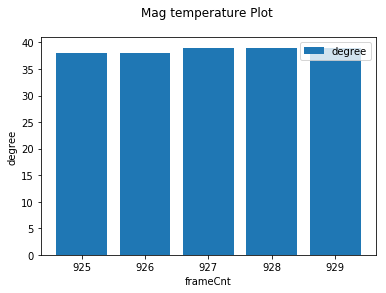

In [741]:
plt.figure()
plt.bar(count, magT, label='degree')
plt.xlabel('frameCnt')
plt.ylabel('degree')
plt.title('Mag temperature Plot \n ')
plt.legend()
plt.show()

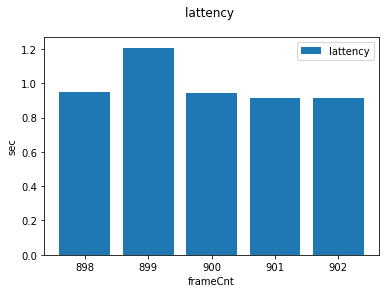

In [718]:
lattency = df.latency_time

plt.figure()
plt.bar(count, lattency, label='lattency')
plt.xlabel('frameCnt')
plt.ylabel('sec')
plt.title('lattency \n ')
plt.legend()
plt.show()

In [ ]:
# latency_time_list = list()
# create_time_list  = list()

# for i in range(len(df.create_at_time)):
#     create_time = get_datetime_from_timeString( df.create_at_time[i] )
#     recv_time   = get_datetime_from_timeString( df.recv_at_time[i] )
#     latency_time = get_two_datetime_delta( recv_time , create_time )
# #     print(latency_time)
#     latency_time_list.append(latency_time)
#     create_time_list.append(latency_time)
    
# df['latency_time'] = latency_time_list

In [45]:
# def get_datetime_from_timeString(date_string):
#     date_string = date_string.replace('T',' ').replace('Z','')
#     datetime_object = datetime.strptime(date_string, '%Y-%m-%d %H:%M:%S.%f')
#     return datetime_object

# def get_two_datetime_delta(datetime_object1 , datetime_object2):
#     datetime_delta   = datetime_object2 - datetime_object1
#     return datetime_delta.total_seconds()

# # date_string1 = "2017-07-26 09:04:33.897"
# # date_string2 = "2017-07-26 09:08:33.897"

# # datetime_object1= get_datetime_from_timeString(date_string1)
# # datetime_object2 = get_datetime_from_timeString(date_string2)
# # latency_time = get_two_datetime_delta(datetime_object1,datetime_object2)
# # latency_time